In [15]:
import argparse
import cv2
import re
import threading

parser = argparse.ArgumentParser(description='Inception V4 Network.')
parser.add_argument('--gpu', default=3, help='GPU to use for train')
parser.add_argument('--name', default="cats_vs_dogs_model", help='Name of the model to use for train')
args, unknown_args = parser.parse_known_args()

In [16]:
import tensorflow as tf
import numpy as np
from scipy.misc import imread, imresize
from os import listdir, environ
import pandas as pd
from IPython import embed
import sys
import random
import time
import os

from datasets import flowers
from nets import inception
from preprocessing import inception_preprocessing

from datasets import dataset_utils

slim = tf.contrib.slim

In [ ]:
BEST_ACC = 0
CHECKPOINTS_DIR = "checkpoints/"

class InceptionV4:
    def __init__(self, model_name, isTraining=True):
        tf.reset_default_graph()
        
        dim = 299
        
        self.X = tf.placeholder(tf.float32, shape=[None, dim,dim,3])
        self.y = tf.placeholder(tf.float32, shape=[None, 2])
        self.learning_rate = tf.placeholder(tf.float32, shape=[])
        
        # -: Data Augmentation :-
        # Randomly crop a [height, width] section of the image.
#         self.X_preproc = tf.map_fn(lambda image: inception_preprocessing.preprocess_image(image, dim, dim), self.X)
#         self.X_preproc = tf.random_crop(self.X, [dim, dim, 3])

#         # Randomly flip the image horizontally.
#         distorted_image = tf.image.random_flip_left_right(distorted_image)

#         # Because these operations are not commutative, consider randomizing
#         # the order their operation.
#         distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
#         distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)

#         # Subtract off the mean and divide by the variance of the pixels.
#         float_image = tf.image.per_image_whitening(distorted_image)
        
        self.X_preproc = tf.map_fn(lambda image: inception_preprocessing.preprocess_image(image, dim, dim, is_training=isTraining), self.X)
        self.best_accuracy = tf.Variable(0.0, trainable=False, name='best_accuracy')

        self.name = model_name
        self.summaries = []
        
        self.__model(isTraining)
        
        self.saver = tf.train.Saver()

        # Just in case a previous run was closed using a halt file.
        if os.path.isfile("{}.halt".format(self.name)):
            os.remove("{}.halt".format(self.name))

        # if weights is not None and sess is not None:
        #     self.load_weights(sess, weights)
    
#     def __get_init_fn(self):
#         """Returns a function run by the chief worker to warm-start the training."""
#         checkpoint_exclude_scopes=["InceptionV4/Logits", "InceptionV4/AuxLogits"]

#         exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

#         variables_to_restore = []
#         for var in slim.get_model_variables():
#             excluded = False
#             for exclusion in exclusions:
#                 if var.op.name.startswith(exclusion):
#                     excluded = True
#                     break
#             if not excluded:
#                 variables_to_restore.append(var)

#         return slim.assign_from_checkpoint_fn(
#           os.path.join(CHECKPOINTS_DIR, 'inception_v4.ckpt'),
#           variables_to_restore)
        
#     def __model(self, isTraining):
#         self.image_size = inception.inception_v4.default_image_size

#         # Create the model, use the default arg scope to configure the batch norm parameters.
#         with slim.arg_scope(inception.inception_v4_arg_scope()):
#             self.logits, self.end_points = inception.inception_v4(self.X, num_classes=2, is_training=isTraining)

#         # Specify the loss function:
# #         slim.losses.softmax_cross_entropy(self.logits, self.y)
# #         self.total_loss = slim.losses.get_total_loss()
#         self.total_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(self.logits, self.y))
        
#         self.probs = self.end_points["Predictions"]

#         # Calculate Accuracy
#         self.correct_prediction = tf.equal(tf.argmax(self.probs, 1), tf.argmax(self.y, 1))
#         self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        
#         self.summaries += [tf.histogram_summary('Correct Predictions', tf.cast(self.correct_prediction, tf.int32))]
#         self.summaries += [tf.histogram_summary('Predictions', tf.argmax(self.probs, 1))]
#         self.summaries += [tf.histogram_summary('Training Labels', tf.argmax(self.y, 1))]
#         self.summaries += [tf.histogram_summary('Activations', self.probs)]
        
#         self.summaries += [tf.scalar_summary('Loss', self.total_loss)]
#         self.summaries += [tf.scalar_summary('Accuracy', self.accuracy)]
#         self.summaries += [tf.scalar_summary('Learning Rate', self.learning_rate)]
#         self.summaries += [tf.scalar_summary('Best Accuracy', self.best_accuracy)]
        
#         # Specify the optimizer and create the train op:
#         self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
#         self.train_step = slim.learning.create_train_op(self.total_loss, self.optimizer)

#         self.init_fn = self.__get_init_fn()

#     def __iterate_minibatches(self, X,y, size):
#         if X.shape[0] % size > 0:
#             raise "The minibatch size should be a divisor of the batch size."

#         idx = np.arange(X.shape[0])
#         np.random.shuffle(idx) # in-place shuffling
#         for i in range(X.shape[0] / size):
#             # To randomize the minibatches every time
#             _idx = idx[i*size:(i+1)*size]
#             yield X[_idx], y[_idx]

#     def __update_screen(self, msg):
#         sys.stdout.write(msg)
#         sys.stdout.flush()

#     def resize_images(self, X):
#         return np.array([ imresize(X[i], (299,299)) for i in range(X.shape[0])])

#     def calculate_loss(self, sess, Xt, yt, size=1000, step=10, learning_rate=0.0):
#         fc3ls = None
#         sample_idx = random.sample(range(0, Xt.shape[0]), size)
#         for i in range(size / step):
#             [fc3l] = sess.run([self.logits], feed_dict={self.X: Xt[sample_idx[i*step:(i+1)*step]], self.y: yt[sample_idx[i*step:(i+1)*step]]})
#             if i == 0:
#                 fc3ls = fc3l
#             else:
#                 fc3ls = np.vstack((fc3ls, fc3l))

#         loss, accuracy, summary = sess.run([self.total_loss, self.accuracy, self.tf_summary], feed_dict={self.logits: fc3ls, self.y: yt[sample_idx], self.learning_rate: learning_rate})

#         return loss, accuracy, summary

#     def __graceful_halt(self, t_start_training):
#         # Save Trained Model
#         p = self.saver.save(sess, "{}.tfmodel".format(self.name))
#         t = time.time() - t_start_training
#         print("++ Training: END -- Exec. Time={0:.0f}m {1:.0f}s Model Path={2:s}".format(t / 60, t % 60, p))


#     def train(self, sess, X, y, val_X, val_y, learning_rate=0.1, epochs=30, minibatch_size=500, optimizer=None):
#         print("++ Training with {} epochs and {} minibatch size.".format(epochs, minibatch_size))
        
#         BEST_ACC = 0
        
#         self.tf_summary = tf.merge_summary(self.summaries)
#         self.tf_logs = tf.train.SummaryWriter("logs/{}".format(self.name), sess.graph, flush_secs=30)
        
#         if optimizer is not None:
#             self.optimizer = optimizer
        
#         # Initialize Model ...
#         sess.run(tf.initialize_all_variables())
#         self.init_fn(sess)
        
#         # Resize Validation Once ...
#         val_X_res = self.resize_images(val_X)
        
#         # I cap the learning rate at 0.001
#         lr_step = (learning_rate - 0.0001) / epochs
#         lr = learning_rate + lr_step
#         step = 0

#         t_start_training = time.time()
#         for i in range(epochs):
#             t_start_epoch = time.time()
#             t_start_minibatch = time.time()
            
#             lr -= lr_step
            
#             print("+++ Epoch {:.0f}: START (lr={:.4f})".format(i, lr))
#             cnt = 0
#             for _X, _y in self.__iterate_minibatches(X, y, minibatch_size):
#                 # Resize Training Batches (to avoid consuming much memeory)
#                 cnt += 1
#                 _X_res = self.resize_images(_X)
#                 self.__update_screen("\r++++ Mini Batch ({} out of {}): ".format(cnt, X.shape[0]/minibatch_size))
#                 sess.run([self.train_step], feed_dict={vgg.X: _X_res, vgg.y: _y, self.learning_rate: lr})
                
#                 if cnt % 25 == 0:
#                     # loss, accuracy = sess.run([self.cross_entropy, self.accuracy], feed_dict={self.X: val_X_res[test_sample], self.y: val_y[test_sample]})
#                     val_loss, val_accuracy, val_summary = self.calculate_loss(sess, val_X_res, val_y, 1000, learning_rate=lr)
#                     t = time.time() - t_start_minibatch
#                     self.__update_screen(" Loss={0:.4f} Accuracy={1:.4f} Exec. Time={2:.0f}m {3:.0f}s\n".format(val_loss, val_accuracy, t / 60, t % 60))
#                     t_start_minibatch = time.time()
                    
#                     # Save Summary
#                     step += 1
#                     self.tf_logs.add_summary(val_summary, step)

#                     # Handle Close Signals
#                     if os.path.isfile("{}.halt".format(self.name)):
#                         self.__graceful_halt(t_start_training)
#                         os.remove("{}.halt".format(self.name))
#                         exit(0)

#             self.__update_screen("\n")
#             val_loss, val_accuracy, val_summary = self.calculate_loss(sess, val_X_res, val_y, val_X.shape[0], learning_rate=lr)
#             t = time.time() - t_start_epoch
#             print("+++ Epoch {:.0f}: END -- Loss={:.4f} Accuracy={:.4f} Exec. Time={:.0f}m {:.0f}s".format(i, val_loss, val_accuracy, t / 60, t % 60))
            
#             # Save Summary
#             step += 1
#             self.tf_logs.add_summary(val_summary, step)

#             # Always Save Best Accuracy
#             if val_accuracy > BEST_ACC:
#                 BEST_ACC = val_accuracy
#                 self.best_accuracy.assign(BEST_ACC)
#                 self.saver.save(sess, "{}.tfmodel".format(self.name))
#                 print("+++ Epoch {0:.0f}: END -- SAVED BEST ACC".format(i))

#         self.__graceful_halt(t_start_training)


#     def predict(self, sess, X):
#         prob = sess.run(vgg.probs, feed_dict={vgg.X: [X]})[0]
#         preds = (np.argsort(prob)[::-1])[0:5]
#         for p in preds:
#             print p, prob[p]



    def load_weights(self, sess, weight_file):
        # This includes optimizer variables as well.
        init = tf.initialize_all_variables()
        sess.run(init)

        weights = np.load(weight_file)
        keys = sorted(weights.keys())
        for i, k in enumerate(keys):
            if i == 30:
                break
            print i, k, np.shape(weights[k])
            sess.run(self.parameters[i].assign(weights[k]))

        # Transfer Learning
        # Initialize the last fully connected layer
        for par in self.parameters[-2:]:
            print("Param: {}".format(par.name))

In [ ]:
def update_screen(msg):
    sys.stdout.write(msg)
    sys.stdout.flush()

In [18]:
def prepare_data():
    TRAIN_DIR = '/home/devyhia/cats.vs.dogs/train/'
    TEST_DIR = '/home/devyhia/cats.vs.dogs/test/'

    ROWS = 299
    COLS = 299
    CHANNELS = 3
    SLICE = 10000

    train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
    train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
    train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

    # test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


    # slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
    train_images = train_dogs[:SLICE] + train_cats[:SLICE]
    valid_images = train_dogs[SLICE:] + train_cats[SLICE:]

    np.random.shuffle(train_images)
    np.random.shuffle(valid_images)

    def read_image(file_path):
        img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
        return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
    
    def assign_image(data, i, image_file):
        data[i] = read_image(image_file).astype(np.float32)

    def prep_data(images):
        count = len(images)
        data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
        
        ts = []
        for i, image_file in enumerate(images):
#             data[i] = read_image(image_file).astype(np.float32)
            t = threading.Thread(target=assign_image, args = (data,i,image_file))
            t.daemon = True
            t.start()
            ts.append(t)
            
        for i,t in enumerate(ts):
            t.join()
            update_screen('\rProcessed {} of {}'.format(i, len(ts)))
        
        update_screen('\n')

        return data

    def get_label(path):
        return 1 if re.search("(cat|dog)\.(\d+)\.", path).group(1) == 'cat' else 0
    
    print("Prep data ...")
    X = prep_data(train_images)
    Xt = prep_data(valid_images)
    # test = prep_data(test_images)
    
#     pre_processing = tf.placeholder(tf.float32, shape=[None, 299,299,3])
#     after_processing = tf.sub(tf.mul(pre_processing, 2.0/255.), 1.0)
    
#     def preprocess(sess, X, i, batch_size):
#         update_screen("\rPreprocessing {} ...".format(i))
#         return sess.run(after_processing, feed_dict={pre_processing: X[i*batch_size:(i+1)*batch_size]})
    
#     with tf.Session() as sess:
#         Xs, Xts = [], []
#         batch_size = 200
        
#         for i in range(X.shape[0] / batch_size):
#             Xs.append(preprocess(sess, X, i, batch_size))
#         update_screen("\n")
        
#         for i in range(Xt.shape[0] / batch_size):
#             Xts.append(preprocess(sess, Xt, i, batch_size))
#         update_screen("\n")
        
#         X = np.vstack(Xs)
#         Xt = np.vstack(Xts)
        
    print("Train shape: {}".format(X.shape))
    print("Valid shape: {}".format(Xt.shape))

    labels_train = [get_label(i) for i in train_images]
    labels_valid = [get_label(i) for i in valid_images]

    print(pd.DataFrame(labels_train, columns=["label"])["label"].value_counts())
    print(pd.DataFrame(labels_valid, columns=["label"])["label"].value_counts())

    y = np.zeros((X.shape[0], 2))
    yt = np.zeros((Xt.shape[0], 2))

    for i in range(y.shape[0]):
        y[i, labels_train[i]] = 1

    for i in range(yt.shape[0]):
        yt[i, labels_valid[i]] = 1

    # print(labels_train)
    # print(labels_valid)

    print(y)
    print(yt)

    print("X=", X.shape, "y=", y.shape)
    print("Xt=", Xt.shape, "yt=", yt.shape)

    return X, y, Xt, yt


def prepare_test_data():
    CACHE_PATH = "cache/Xt.npy"
    if os.path.isfile(CACHE_PATH):
        data = np.load(CACHE_PATH)
        return range(1, data.shape[0]+1), data

    TEST_DIR = '/home/devyhia/cats.vs.dogs/test/'

    ROWS = 224
    COLS = 224
    CHANNELS = 3

    file_key = lambda f: int(re.match("(\d+)\.jpg", f).group(1))
    test_images =  [TEST_DIR+i for i in sorted(os.listdir(TEST_DIR), key=file_key)]

    def read_image(file_path):
        img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
        return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


    def prep_data(images):
        count = len(images)
        data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
        ids = []

        for i, image_file in enumerate(images):
            data[i] = read_image(image_file)
            ids.append(re.search("(\d+)\.", image_file).group(1))

            if i%250 == 0: update_screen('\rProcessed {} of {}'.format(i, count))
        
        update_screen('\n')
        
        return ids, data

    ids, data = prep_data(test_images)

    np.save(CACHE_PATH, data)

    return ids, data

In [12]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu)

vgg = InceptionV4(args.name)

sess = tf.Session()

In [19]:
X, y, Xt, yt = prepare_data()

Prep data ...
Processed 19999 of 20000
Processed 4999 of 5000
Train shape: (20000, 299, 299, 3)
Valid shape: (5000, 299, 299, 3)
1    10000
0    10000
Name: label, dtype: int64
1    2500
0    2500
Name: label, dtype: int64
[[ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 ..., 
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]]
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]
('X=', (20000, 299, 299, 3), 'y=', (20000, 2))
('Xt=', (5000, 299, 299, 3), 'yt=', (5000, 2))


In [37]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# from random import randint

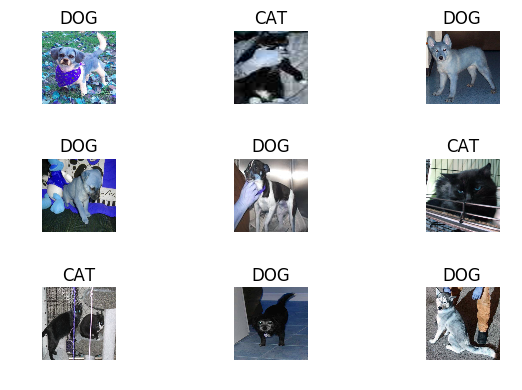

In [39]:
# fig, ax = plt.subplots(3,3)
# for i in range(3):
#     for j in range(3):
#         Idx = randint(0, X.shape[0])
#         ax[i, j].imshow(X[Idx])
#         ax[i, j].set_title("CAT" if y.argmax(axis=1)[Idx] == 1 else "DOG")
#         ax[i,j].axis('off')
# plt.tight_layout()

In [ ]:
# optimizer=tf.train.AdadeltaOptimizer(epsilon=0.1, learning_rate=0.001)
vgg.train(sess, X, y, Xt, yt, minibatch_size=50, learning_rate=0.01)